# Model Selection on the Enron Dataset (KNN vs GNB vs DTree)

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, confusion_matrix

In [2]:
import sys
import pickle
import numpy as np
import pprint
from tabulate import tabulate 

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from sklearn.cross_validation import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from tester import test_classifier
from wrappers import BestFirstSearchWrapper, RandomSubsetsWrapper

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt


In [4]:
from data_cleaning import clean_dataset
from feature_engineering import feature_engineering

my_dataset = clean_dataset(pickle.load(open("final_project_dataset.pkl", "r") ))
my_dataset, feature_names = feature_engineering(my_dataset)
data = featureFormat(my_dataset, feature_names, remove_all_zeroes=False)
labels, features = targetFeatureSplit(data)


In [5]:
from feature_scaling import SigmoidMinMaxScaler

In [7]:
anova_filter = SelectKBest()
cv = StratifiedShuffleSplit(labels, n_iter=1000, random_state=42)

In [8]:
from sklearn.base import clone
def anova_test(model,ks,parameters,scoring=min_of_prec_rec,cv=cv):
    results = []
    for k in ks:
        
        anova = SelectKBest(k=k).fit(features, labels)
        F = anova.transform(features)
        k_res = []
        for params in ParameterGrid(parameters):
            minstance = clone(model).set_params(**params)
            scores = cross_val_score(minstance, X=F, y=labels, scoring=scoring, cv=cv)
        
            k_res.append((np.mean(scores),params,anova,scores))
        results.append(sorted(k_res, reverse=True, key=lambda x: x[0]))
    return results
anova_k = [1,3,5,10,15,20,len(feature_names)-1]

def bfs_test(model, parameters, scoring=min_of_prec_rec, cv=cv):
    results = []
    for params in ParameterGrid(parameters):
        minstance = clone(model)
        minstance = minstance.set_params(**params).fit(features, labels)
        scores = cross_val_score(minstance, X=features, y=labels, scoring=scoring, cv=cv)
    
        results.append((np.mean(scores), params, minstance, scores))
    
    return results



def get_fnames(inds):
    return ['poi'] + list(np.array(feature_names[1:])[inds])
def boxplot_with_labels(data, labels, *args, **kwargs):
    plt.boxplot(data, *args, **kwargs)
    ax1 = plt.gca()
    xtickNames = plt.setp(ax1,xticklabels=labels)
    _ = plt.setp(xtickNames, rotation=45, fontsize=8)
from itertools import chain
def flatten(listOfLists):
    "Flatten one level of nesting"
    return chain.from_iterable(listOfLists)

# KNN

### With Anova Feature Selection

In [9]:

knn_pipeline = Pipeline([
    ('scaler', SigmoidMinMaxScaler()),
	('knn', KNeighborsClassifier())
])


parameters = {
	'knn__n_neighbors': [1,3,5],
}


anova_results = anova_test(knn_pipeline, anova_k, parameters, scoring='f1', cv=cv)


    

/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


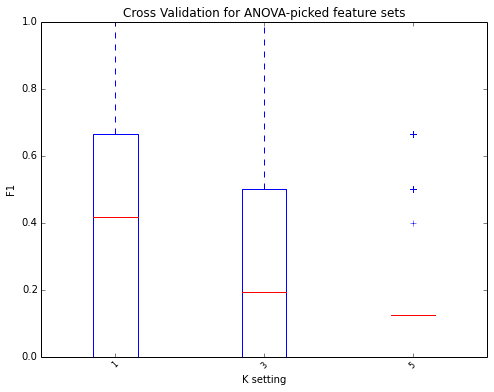

In [11]:
ms,_,anova,scores = zip(*sorted(anova_results[-1], key=lambda x: x[1]['knn__n_neighbors']))
plt.figure(figsize=(8,6))
boxplot_with_labels(scores, [1,3,5], usermedians=ms)
plt.title('Cross Validation for ANOVA-picked feature sets')
plt.xlabel('K setting')
plt.ylabel('F1')
plt.savefig('CV-ANOVA-KNN.png')

In [12]:
fnames = get_fnames(np.nonzero(anova[0].get_support()))

knn_anova_clf = Pipeline([('scaler', SigmoidMinMaxScaler()),('knn', KNeighborsClassifier(n_neighbors=1))])

test_classifier(knn_anova_clf, my_dataset, fnames, folds = 1000)

Pipeline(steps=[('scaler', SigmoidMinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform'))])
	Accuracy: 0.88727	Precision: 0.63060	Recall: 0.37300	F1: 0.46874	F2: 0.40619
	Total predictions: 15000	True positives:  746	False positives:  437	False negatives: 1254	True negatives: 12563



In [13]:
headers = ['Num Features', 'K', 'Mean F1', 'F1 Std.']
rows = map(lambda (m,param,anova,sc):[anova.k,param['knn__n_neighbors'],m,sc.std()],flatten(anova_results))
print tabulate(rows, headers, tablefmt='latex')

\begin{tabular}{rrrr}
\hline
   Num Features &   K &    Mean F1 &   F1 Std. \\
\hline
              1 &   1 & 0.23478    & 0.264004  \\
              1 &   3 & 0.172467   & 0.281428  \\
              1 &   5 & 0.0684667  & 0.196715  \\
              3 &   1 & 0.353157   & 0.310312  \\
              3 &   3 & 0.348371   & 0.352423  \\
              3 &   5 & 0.300967   & 0.340049  \\
              5 &   3 & 0.162757   & 0.254256  \\
              5 &   1 & 0.122878   & 0.219711  \\
              5 &   5 & 0.0700524  & 0.196802  \\
             10 &   1 & 0.169362   & 0.253606  \\
             10 &   3 & 0.0656667  & 0.194334  \\
             10 &   5 & 0.0395667  & 0.156383  \\
             15 &   1 & 0.221795   & 0.287486  \\
             15 &   3 & 0.0539667  & 0.172922  \\
             15 &   5 & 0.00596667 & 0.0603781 \\
             20 &   1 & 0.207407   & 0.282396  \\
             20 &   5 & 0.1002     & 0.232966  \\
             20 &   3 & 0.0723333  & 0.199324  \\
             2

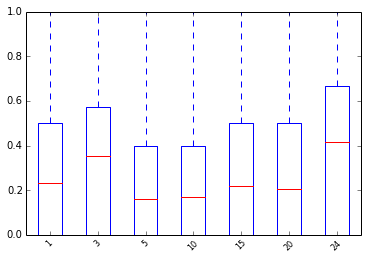

In [14]:
ms,_,_,scores = zip(*map(lambda x: x[0], anova_results))

boxplot_with_labels(scores, anova_k, usermedians=ms)

### With BestFirstSearchWrapper Feature Selection

In [15]:

parameters = {
	'knn__estimator__n_neighbors': [1,3,5],
}
knn_pipeline = Pipeline([
        ('scaler', SigmoidMinMaxScaler()),
        ('knn', BestFirstSearchWrapper(KNeighborsClassifier(), scoring='f1'))
    ])
bfs_results = bfs_test(knn_pipeline, parameters, scoring='f1', cv=cv)


New best score: -0.411111111111
New best score: -0.423206423206
New best score: -0.469696969697
New best score: -0.485185185185
New best score: -0.50641025641
New best score: -0.53367003367
New best score: -0.551587301587
New best score: -0.31746031746
New best score: -0.331135531136
New best score: -0.417378917379
New best score: -0.448148148148
New best score: -0.466666666667
New best score: -0.481818181818
New best score: -0.525252525253
New best score: -0.21645021645
New best score: -0.430976430976
New best score: -0.449494949495
New best score: -0.5
New best score: -0.536363636364


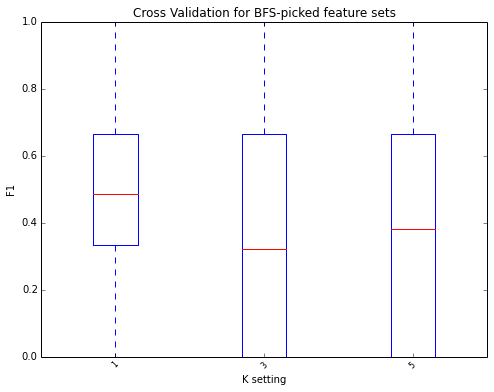

In [16]:
ms,_,_,scores = zip(*bfs_results)
plt.figure(figsize=(8,6))
boxplot_with_labels(scores, [1,3,5], usermedians=ms)
plt.title('Cross Validation for BFS-picked feature sets')
plt.xlabel('K setting')
plt.ylabel('F1')
plt.savefig('CV-BFS-KNN.png')

In [17]:
_,_,pline,_ = sorted(bfs_results, reverse=True)[0]

wrapper = pline.named_steps['knn']
knnmodel = wrapper.estimator

In [18]:
fnames = get_fnames(list(wrapper.best_subset))
print fnames

['poi', 'prop_shared_with_poi', 'total_payments', 'restricted_stock_deferred', 'prop_rest_stock', 'from_messages', 'deferral_payments', 'prop_exercised_stock', 'shared_receipt_with_poi', 'to_messages', 'from_poi_to_this_person']


In [19]:

knn_bfs_clf = Pipeline([('scaler', SigmoidMinMaxScaler()),('knn', knnmodel)])
test_classifier(knn_bfs_clf, my_dataset, fnames, folds = 1000)

Pipeline(steps=[('scaler', SigmoidMinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform'))])
	Accuracy: 0.87627	Precision: 0.53896	Recall: 0.49800	F1: 0.51767	F2: 0.50569
	Total predictions: 15000	True positives:  996	False positives:  852	False negatives: 1004	True negatives: 12148



In [20]:

headers = ['K','Length of best subset','Mean F1', 'Std. F1']
rows = map(lambda (m,par,wr,sc): par.values() + [len(wr.named_steps['knn'].best_subset), m, sc.std()], bfs_results)
print tabulate(rows, headers, tablefmt='latex')

\begin{tabular}{rrrr}
\hline
   K &   Length of best subset &   Mean F1 &   Std. F1 \\
\hline
   1 &                      10 &  0.484879 &  0.314204 \\
   3 &                       9 &  0.3224   &  0.332239 \\
   5 &                       5 &  0.380233 &  0.350437 \\
\hline
\end{tabular}


### Trying to improve the feature set for the best classifier (n_neighbors=1)

In [21]:
knn_wrapper = Pipeline([
    ('scaler', SigmoidMinMaxScaler()),
    ('knn', BestFirstSearchWrapper(KNeighborsClassifier(n_neighbors=1), scoring='f1', 
                                   cv=StratifiedShuffleSplit(labels,n_iter=300,random_state=42),
                                   initial_subset=wrapper.best_subset))
]).fit(features, labels)
    

New best score: -0.546164021164
New best score: -0.598634920635
New best score: -0.609031746032


In [22]:
fnames = get_fnames(list(knn_wrapper.named_steps['knn'].best_subset))
print len(fnames), fnames

13 ['poi', 'prop_shared_with_poi', 'total_payments', 'restricted_stock_deferred', 'prop_rest_stock', 'from_messages', 'deferral_payments', 'prop_exercised_stock', 'shared_receipt_with_poi', 'to_messages', 'from_poi_to_this_person', 'total_stock_value', 'from_this_person_to_poi']


In [23]:
knn_bfs_clf = Pipeline([('scaler', SigmoidMinMaxScaler()),('knn', KNeighborsClassifier(n_neighbors=1))])
test_classifier(knn_bfs_clf, my_dataset, fnames, folds = 1000)

Pipeline(steps=[('scaler', SigmoidMinMaxScaler(copy=True, feature_range=(0, 1))), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform'))])
	Accuracy: 0.90093	Precision: 0.64294	Recall: 0.57800	F1: 0.60874	F2: 0.58992
	Total predictions: 15000	True positives: 1156	False positives:  642	False negatives:  844	True negatives: 12358



# Gaussian Naive Bayes

### With ANOVA Feature Selection

In [24]:

gnb_pipeline = Pipeline([
	('scaler', SigmoidMinMaxScaler()),
	('gnb',  GaussianNB())
	])


grid_gnb = anova_test(gnb_pipeline, anova_k, {}, cv=cv, scoring='f1')



In [25]:
score, _, anova, scores = sorted(map(lambda x: x[0], grid_gnb), reverse=True)[0]
fnames = get_fnames(np.nonzero(anova.get_support()))

In [26]:

gnb_anova_clf = Pipeline([('scaler', SigmoidMinMaxScaler()),('gnb', GaussianNB())])
test_classifier(gnb_anova_clf, my_dataset, fnames, folds = 1000)

Pipeline(steps=[('scaler', SigmoidMinMaxScaler(copy=True, feature_range=(0, 1))), ('gnb', GaussianNB())])
	Accuracy: 0.67967	Precision: 0.23692	Recall: 0.63150	F1: 0.34456	F2: 0.47371
	Total predictions: 15000	True positives: 1263	False positives: 4068	False negatives:  737	True negatives: 8932



In [27]:
headers = ['Num Features', 'Mean F1', 'F1 Std.']
rows = map(lambda (m,_,anova,sc):[anova.k,m,sc.std()],flatten(grid_gnb))
print tabulate(rows, headers, tablefmt='latex')

\begin{tabular}{rrr}
\hline
   Num Features &   Mean F1 &   F1 Std. \\
\hline
              1 &  0.303233 &  0.333306 \\
              3 &  0.334438 &  0.317345 \\
              5 &  0.297906 &  0.306209 \\
             10 &  0.320381 &  0.312564 \\
             15 &  0.285421 &  0.304204 \\
             20 &  0.354962 &  0.232852 \\
             24 &  0.368971 &  0.210408 \\
\hline
\end{tabular}


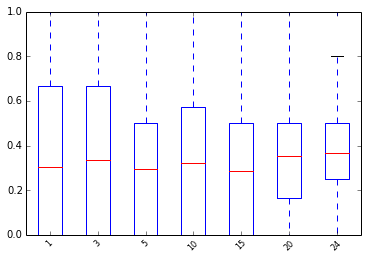

In [28]:
ms,_,_,scores = zip(*map(lambda x: x[0], grid_gnb))

boxplot_with_labels(scores, anova_k, usermedians=ms)

### With the BestFirstSearchWrapper Feature Selection

In [29]:
gnb_pipeline = Pipeline([
    ('scaler', SigmoidMinMaxScaler()),
    ('gnb', BestFirstSearchWrapper(GaussianNB(), scoring='f1'))
    ])

gnb_best = gnb_pipeline.fit(features, labels)
wrapper = gnb_best.named_steps['gnb']

fnames = get_fnames(list(wrapper.best_subset))
print fnames

New best score: -0.320512820513
New best score: -0.460317460317
New best score: -0.498412698413
New best score: -0.513227513228
New best score: -0.52904040404
New best score: -0.546897546898
['poi', 'exercised_stock_options', 'deferred_income', 'from_poi_to_this_person', 'from_messages', 'expenses', 'prop_to_poi', 'from_this_person_to_poi', 'prop_exercised_stock']


In [30]:
gnb_bfs_clf = Pipeline([('scaler', SigmoidMinMaxScaler()),('gnb', GaussianNB())])
test_classifier(gnb_bfs_clf, my_dataset, fnames, folds = 1000)

Pipeline(steps=[('scaler', SigmoidMinMaxScaler(copy=True, feature_range=(0, 1))), ('gnb', GaussianNB())])
	Accuracy: 0.84153	Precision: 0.39235	Recall: 0.34350	F1: 0.36630	F2: 0.35227
	Total predictions: 15000	True positives:  687	False positives: 1064	False negatives: 1313	True negatives: 11936



### Trying to improve the feature set with more CV

In [31]:
gnb_pipeline = Pipeline([
    ('scaler', SigmoidMinMaxScaler()),
    ('gnb', BestFirstSearchWrapper(GaussianNB(), scoring='f1', 
                                 cv=StratifiedShuffleSplit(labels, n_iter=300, random_state=42),
                                  initial_subset=wrapper.best_subset))
    ])

gnb_best = gnb_pipeline.fit(features, labels)

New best score: -0.32108994709
New best score: -0.334851851852
New best score: -0.358582010582
New best score: -0.371841269841
New best score: -0.393888888889
New best score: -0.426349206349


In [32]:
fnames = get_fnames(list(gnb_best.named_steps['gnb'].best_subset))
print fnames

['poi', 'exercised_stock_options', 'deferred_income', 'from_messages', 'expenses', 'prop_exercised_stock', 'total_stock_value', 'long_term_incentive', 'salary']


In [33]:
gnb_bfs_clf = Pipeline([('scaler', SigmoidMinMaxScaler()),('gnb', GaussianNB())])
test_classifier(gnb_bfs_clf, my_dataset, fnames, folds = 1000)

Pipeline(steps=[('scaler', SigmoidMinMaxScaler(copy=True, feature_range=(0, 1))), ('gnb', GaussianNB())])
	Accuracy: 0.86213	Precision: 0.48113	Recall: 0.43350	F1: 0.45608	F2: 0.44226
	Total predictions: 15000	True positives:  867	False positives:  935	False negatives: 1133	True negatives: 12065



## Decision Trees

### With built in feature selection

In [34]:
dtree_pipeline = Pipeline([
	('scaler', SigmoidMinMaxScaler()),
	('dtree', DecisionTreeClassifier())
	])

parameters = {'dtree__max_depth':[2,8,16],
              'dtree__max_features': anova_k,
              'dtree__class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:5}]}

grid_dtree = GridSearchCV(dtree_pipeline, parameters, cv=cv, scoring='f1', iid=False)
grid_dtree = grid_dtree.fit(features, labels)


In [35]:
clf = grid_dtree.best_estimator_
test_classifier(clf, my_dataset, feature_names, folds = 1000)

Pipeline(steps=[('scaler', SigmoidMinMaxScaler(copy=True, feature_range=(0, 1))), ('dtree', DecisionTreeClassifier(class_weight={0: 1, 1: 5}, criterion='gini',
            max_depth=2, max_features=15, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=None,
            splitter='best'))])
	Accuracy: 0.77600	Precision: 0.31720	Recall: 0.59000	F1: 0.41259	F2: 0.50341
	Total predictions: 15000	True positives: 1180	False positives: 2540	False negatives:  820	True negatives: 10460



In [36]:
headers = ['Num Features','Class Weight','Max Depth','Mean F1', 'F1 Std.']
rows = []
for i in anova_k:
    best = sorted(filter(lambda x: x.parameters['dtree__max_features']==i, grid_dtree.grid_scores_), 
                  key=lambda x: x.mean_validation_score, reverse=True)[0]
    rows.append([i,best.parameters['dtree__class_weight'],best.parameters['dtree__max_depth'],
                 best.mean_validation_score,best.cv_validation_scores.std()])

print tabulate(rows,headers, tablefmt='latex')

\begin{tabular}{rlrrr}
\hline
   Num Features & Class Weight   &   Max Depth &   Mean F1 &   F1 Std. \\
\hline
              1 & \{0: 1, 1: 5\}   &           2 &  0.324614 &  0.246641 \\
              3 & \{0: 1, 1: 5\}   &           2 &  0.376725 &  0.240115 \\
              5 & \{0: 1, 1: 5\}   &           2 &  0.380175 &  0.253454 \\
             10 & \{0: 1, 1: 5\}   &           2 &  0.40747  &  0.257806 \\
             15 & \{0: 1, 1: 5\}   &           2 &  0.418131 &  0.254004 \\
             20 & \{0: 1, 1: 5\}   &           2 &  0.411994 &  0.237423 \\
             24 & \{0: 1, 1: 5\}   &           2 &  0.394084 &  0.215797 \\
\hline
\end{tabular}


In [37]:
header = ['Max Features', 'Misclassification Costs','Max Depth','Mean Validation Score']
rows = map(lambda x: x.parameters.values() + [x.mean_validation_score], grid_dtree.grid_scores_)
print tabulate(rows, header, tablefmt='latex')

\begin{tabular}{rlrr}
\hline
   Max Features & Misclassification Costs   &   Max Depth &   Mean Validation Score \\
\hline
              1 & \{0: 1, 1: 1\}              &           2 &               0.0830333 \\
              3 & \{0: 1, 1: 1\}              &           2 &               0.144974  \\
              5 & \{0: 1, 1: 1\}              &           2 &               0.177566  \\
             10 & \{0: 1, 1: 1\}              &           2 &               0.184892  \\
             15 & \{0: 1, 1: 1\}              &           2 &               0.16544   \\
             20 & \{0: 1, 1: 1\}              &           2 &               0.140375  \\
             24 & \{0: 1, 1: 1\}              &           2 &               0.120997  \\
              1 & \{0: 1, 1: 1\}              &           8 &               0.238923  \\
              3 & \{0: 1, 1: 1\}              &           8 &               0.282813  \\
              5 & \{0: 1, 1: 1\}              &           8 &               

### With BestFirstSearchWrapper Feature Selection

In [38]:
parameters = {'dtree__estimator__max_depth':[2,8,16],
              'dtree__estimator__class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:5}]}
dtree_pipeline = Pipeline([
    ('scaler', SigmoidMinMaxScaler()),
    ('dtree', BestFirstSearchWrapper(DecisionTreeClassifier(), 
                                     scoring='f1',
                                    cv=StratifiedShuffleSplit(labels,n_iter=30,random_state=42)))
    ])
dtree_bfs_results = bfs_test(dtree_pipeline, parameters)


New best score: -0.222222222222
New best score: -0.322222222222
New best score: -0.372222222222
New best score: -0.388412698413
New best score: -0.450634920635
New best score: -0.465079365079
New best score: -0.477777777778
New best score: -0.51
New best score: -0.372222222222
New best score: -0.385714285714
New best score: -0.399047619048
New best score: -0.428412698413
New best score: -0.478888888889
New best score: -0.506666666667
New best score: -0.244444444444
New best score: -0.601111111111
New best score: -0.298888888889
New best score: -0.39
New best score: -0.412222222222
New best score: -0.474603174603
New best score: -0.506666666667
New best score: -0.53
New best score: -0.557301587302
New best score: -0.572857142857
New best score: -0.584285714286
New best score: -0.305079365079
New best score: -0.362222222222
New best score: -0.458888888889
New best score: -0.47
New best score: -0.544365079365
New best score: -0.636031746032
New best score: -0.326666666667
New best score: 

/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
s,_,pline,_ = sorted(dtree_bfs_results, reverse=True)[0]
print s
wrapper = pline.named_steps['dtree']
knnmodel = wrapper.estimator

fnames = ['poi']+list(np.array(feature_names[1:])[list(wrapper.best_subset)])
print fnames

0.490282539683
['poi', 'prop_to_poi', 'expenses']


In [40]:
clf = Pipeline([('scaler',SigmoidMinMaxScaler()), ('dtree', knnmodel)])
test_classifier(clf, my_dataset, fnames, folds = 1000)

Pipeline(steps=[('scaler', SigmoidMinMaxScaler(copy=True, feature_range=(0, 1))), ('dtree', DecisionTreeClassifier(class_weight={0: 1, 1: 5}, criterion='gini',
            max_depth=2, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=None,
            splitter='best'))])
	Accuracy: 0.86400	Precision: 0.49283	Recall: 0.68700	F1: 0.57393	F2: 0.63682
	Total predictions: 15000	True positives: 1374	False positives: 1414	False negatives:  626	True negatives: 11586



In [41]:

headers = ['Misclassification Costs','Max Depth','Length of best Subset','Mean F1', 'Std. F1']
rows = map(lambda (m,par,wr,sc): par.values() + [len(wr.named_steps['dtree'].best_subset), m, sc.std()], dtree_bfs_results)
print tabulate(rows, headers, tablefmt='latex')

\begin{tabular}{lrrrr}
\hline
 Misclassification Costs   &   Max Depth &   Length of best Subset &   Mean F1 &   Std. F1 \\
\hline
 \{0: 1, 1: 1\}              &           2 &                       2 &  0.277333 &  0.295668 \\
 \{0: 1, 1: 1\}              &           8 &                       7 &  0.343117 &  0.283406 \\
 \{0: 1, 1: 1\}              &          16 &                       8 &  0.302244 &  0.28239  \\
 \{0: 1, 1: 2\}              &           2 &                       2 &  0.474817 &  0.277713 \\
 \{0: 1, 1: 2\}              &           8 &                       9 &  0.36997  &  0.273104 \\
 \{0: 1, 1: 2\}              &          16 &                       4 &  0.323233 &  0.300483 \\
 \{0: 1, 1: 5\}              &           2 &                       2 &  0.490283 &  0.246631 \\
 \{0: 1, 1: 5\}              &           8 &                      10 &  0.379067 &  0.274403 \\
 \{0: 1, 1: 5\}              &          16 &                       8 &  0.441213 &  0.31671  \\
\hlin

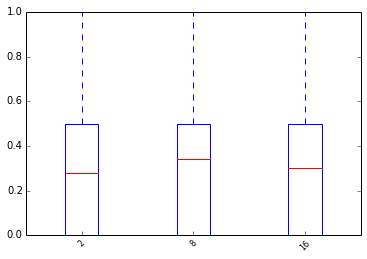

In [42]:
ms,params,_,scores = zip(*filter(lambda x: x[1]['dtree__estimator__class_weight'][1]==1, dtree_bfs_results))
boxplot_labels = map(lambda x: x['dtree__estimator__max_depth'], params)
boxplot_with_labels(scores, boxplot_labels, usermedians=ms)

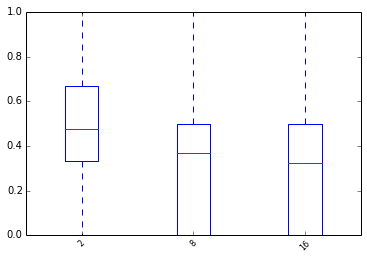

In [43]:
ms,params,_,scores = zip(*filter(lambda x: x[1]['dtree__estimator__class_weight'][1]==2, dtree_bfs_results))
boxplot_labels = map(lambda x: x['dtree__estimator__max_depth'], params)
boxplot_with_labels(scores, boxplot_labels, usermedians=ms)

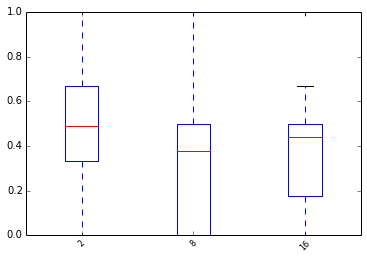

In [44]:
ms,params,_,scores = zip(*filter(lambda x: x[1]['dtree__estimator__class_weight'][1]==5, dtree_bfs_results))
boxplot_labels = map(lambda x: x['dtree__estimator__max_depth'], params)
boxplot_with_labels(scores, boxplot_labels, usermedians=ms)

In [45]:
mclf = clf.fit(np.array(features)[:,list(wrapper.best_subset)], labels)

In [46]:
from sklearn.externals.six import StringIO  
import pydot 
from sklearn.tree import export_graphviz

dot_data = StringIO() 
export_graphviz(mclf.named_steps['dtree'], out_file=dot_data, feature_names=fnames[1:]) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

In [47]:
from IPython.display import Image

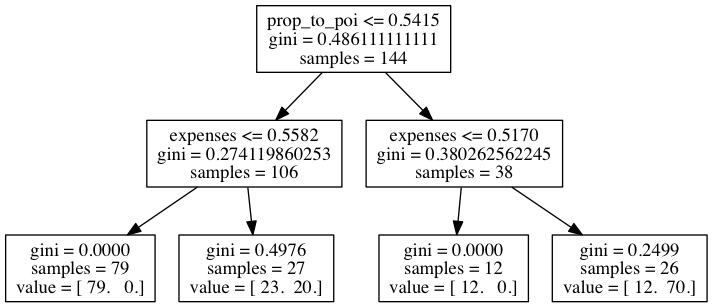

In [48]:
Image(graph.create_png())

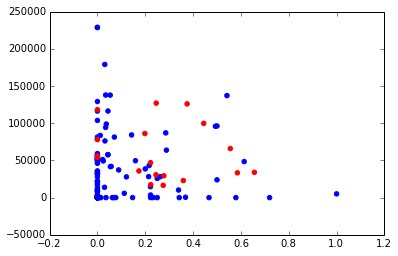

In [49]:
neg = np.array(features)[np.array(labels)==0,:][:,list(wrapper.best_subset)]
pos = np.array(features)[np.array(labels)==1,:][:,list(wrapper.best_subset)]
plt.scatter(*neg.transpose(), color='b')
plt.scatter(*pos.transpose(), color='r')

In [50]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
neg.shape

(126, 2)